## Import

In [ ]:
from os.path import exists
if not exists('fmix.zip'):
  ! wget -O fmix.zip https://github.com/ecs-vlc/fmix/archive/master.zip
  ! unzip -qq fmix.zip
  ! mv FMix-master/* ./
  ! rm -r FMix-master
from fmix import sample_and_apply

!pip install -U rich
!pip install rich -U

!pip install -qqq ipywidgets
!pip install -qqq timm
import rich
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install -qqq pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

# create your own theme!
progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="#8ec5fc",
        progress_bar="#8ec5fc",
        progress_bar_finished="#8ec5fc",
        # progress_bar_pulse="#8ec5fc",
        batch_progress="#8ec5fc",
        time="#8ec5fc",
        processing_speed="#8ec5fc",
        metrics="#8ec5fc",
    ), leave=True
)

import torchmetrics
import timm

!pip install -qqq torchsummary
from torchsummary import summary

from torch.utils.data import DataLoader

import os
import sys
import glob
import pathlib

import re
import math
import random
import numpy as np
import pandas as pd

from typing import Callable, Dict, Optional, Tuple

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
# plt.style.use("ggplot")

import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.composition import Compose, OneOf

import cv2

print(f'Pytorch version: {torch.__version__}')
print(f'PyTorch Lightning version: {pl.__version__}')
print(f'Albumentations version: {A.__version__}')
print(f'Timm version: {timm.__version__}')
print(f'Python version: P{sys.version}')

import warnings
warnings.filterwarnings('ignore')

--2022-08-23 12:49:29--  https://github.com/ecs-vlc/fmix/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ecs-vlc/FMix/zip/refs/heads/master [following]
--2022-08-23 12:49:29--  https://codeload.github.com/ecs-vlc/FMix/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘fmix.zip’

fmix.zip                [ <=>                ] 983.14K  --.-KB/s    in 0.08s   

2022-08-23 12:49:29 (12.8 MB/s) - ‘fmix.zip’ saved [1006735]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 23.4 MB/s 
     |█████████

## Config

In [ ]:
class CFG:
    model_name = 'tf_efficientnet_b0_ns'
    pretrained = True
    num_classes = 0

    image_size = 640
    crop_size = 0.9
    fold = 0
    n_splits = 5
    n = 0
    
    num_epochs = 30
    batch_size = 32
    
    lr = 1e-4
    max_lr = 2e-3
    weight_decay = 1e-6
    
    precision = 16
    num_workers = 4
    seed = 42
    
    steps_per_epoch = 1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Download data

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c paddy-disease-classification
!unzip -qqq paddy-disease-classification.zip

 98% 1.00G/1.02G [00:05<00:00, 177MB/s]
100% 1.02G/1.02G [00:05<00:00, 208MB/s]


## CSV Preparation

In [ ]:
TRAIN_DIR = "/content/train_images"

def process(data):
    path=pathlib.Path(data)
    filepaths=list(path.glob(r"*/*.jpg"))
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
    df1=pd.Series(filepaths,name='file_path').astype(str)
    df2=pd.Series(labels,name='label')
    df=pd.concat([df1,df2],axis=1)
    
    return df

In [ ]:
df = process(TRAIN_DIR)
df['image_id'] = df['file_path'].apply(lambda image:image.split('/')[-1])
df.head()

,file_path,label,image_id
0,/content/train_images/tungro/102104.jpg,tungro,102104.jpg
1,/content/train_images/tungro/100207.jpg,tungro,100207.jpg
2,/content/train_images/tungro/105205.jpg,tungro,105205.jpg
3,/content/train_images/tungro/102678.jpg,tungro,102678.jpg
4,/content/train_images/tungro/104785.jpg,tungro,104785.jpg


In [ ]:
num_classes  = df['label'].nunique()
print(f'num_classes : {num_classes}')

CFG.num_classes = num_classes

num_classes : 10


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

encoder = LabelEncoder()
label2index = {l: i for (i, l) in enumerate(encoder.fit(df["label"]).classes_)}
index2label = {x[1]: x[0] for x in label2index.items()}

df["label_index"] = encoder.fit_transform(df["label"])

skf = StratifiedKFold(n_splits=CFG.n_splits)
for fold, (_, val_) in enumerate(skf.split(X=df, y=df.label)):
    df.loc[val_, "fold"] = fold

df.head()

,file_path,label,image_id,label_index,fold
0,/content/train_images/tungro/102104.jpg,tungro,102104.jpg,9,0.0
1,/content/train_images/tungro/100207.jpg,tungro,100207.jpg,9,0.0
2,/content/train_images/tungro/105205.jpg,tungro,105205.jpg,9,0.0
3,/content/train_images/tungro/102678.jpg,tungro,102678.jpg,9,0.0
4,/content/train_images/tungro/104785.jpg,tungro,104785.jpg,9,0.0


In [ ]:
TEST_DIR = "/content/test_images/" 

test_df = pd.read_csv("/content/sample_submission.csv")
test_df["file_path"] = test_df["image_id"].apply(lambda image: TEST_DIR + image)
test_df['label'] = -1
test_df["label_index"] = -1
test_df.head()

,image_id,label,file_path,label_index
0,200001.jpg,-1,/content/test_images/200001.jpg,-1
1,200002.jpg,-1,/content/test_images/200002.jpg,-1
2,200003.jpg,-1,/content/test_images/200003.jpg,-1
3,200004.jpg,-1,/content/test_images/200004.jpg,-1
4,200005.jpg,-1,/content/test_images/200005.jpg,-1


## Dataset

In [ ]:
class VisionDataset(torch.utils.data.Dataset):
    def __init__(self, df_, transforms=None, test=False):
        self.image_path = df_['file_path'].values
        self.labels = df_["label_index"].values
        self.ids = df_['image_id']
        self.transforms = transforms
        self.test = test

    def __len__(self):
        return len(self.image_path)
    
    def resize(self, image, interp):
        return  cv2.resize(image, (CFG.image_size, CFG.image_size), interpolation=interp)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        label = self.labels[index]
        image_id = self.ids[index]
        
        image_path = self.image_path[index]
        image = cv2.imread(image_path, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.resize(image, cv2.INTER_AREA)
        
        if self.transforms is not None:
            result = self.transforms(image=image)
            image = result['image']
        
        if self.test:
            return {'image':image, 'target': image_id}
        else:
            return {'image':image, 'target': label}

## Lightning DataModule

In [ ]:
class LitDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.df = df
        self.test_df = test_df
        self.train_transforms, self.valid_transform = self.init_transforms()
        

    def init_transforms(self):
        crop_size = round(CFG.image_size*CFG.crop_size)
        train_transforms = Compose([
            A.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            A.Affine(rotate=(-15, 15), translate_percent=(0.0, 0.25), shear=(-3, 3), p=0.7),
            # A.Cutout(max_h_size=int(crop_size * 0.4), max_w_size=int(crop_size * 0.4), num_holes=1, p=0.5),
            A.RandomGridShuffle(grid=(2, 2), p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.05),
            A.RandomSnow(p=0.05),
            A.RandomRain(p=0.05),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
            ToTensorV2(),
        ])
        
        valid_transform = Compose([
            A.CenterCrop(height=crop_size, width=crop_size, always_apply=True),
            A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],),
            ToTensorV2(),
        ])
            
        return train_transforms, valid_transform
        

    def setup(self, stage: Optional[str] = None):
        
        if stage == "fit" or stage is None:
            train_df = self.df[self.df.fold != CFG.n].reset_index(drop=True)
            val_df = self.df[self.df.fold == CFG.n].reset_index(drop=True)
        
            self.train_dataset = VisionDataset(train_df, transforms=self.train_transforms)
            self.valid_dataset = VisionDataset(val_df, transforms=self.valid_transform)
            
            self.test_dataset = VisionDataset(self.test_df, transforms=self.train_transforms, test=True)
   

    def train_dataloader(self) -> DataLoader:
        return self.dataloader(self.train_dataset, train=True)


    def val_dataloader(self) -> DataLoader:
        return self.dataloader(self.valid_dataset)
    
    def test_dataloader(self) -> DataLoader:
        return self.dataloader(self.test_dataset)
    

    def dataloader(self, dataset: VisionDataset, train: bool = False) -> DataLoader:
        return DataLoader(
            dataset,
            batch_size=CFG.batch_size,
            shuffle=train,
            num_workers=CFG.num_workers,
            pin_memory=True,
            drop_last=train,
        )

In [ ]:
def mixup(imgs, labels, alpha):
  lam = np.random.beta(alpha,alpha)
  index = torch.randperm(len(imgs))
  shuffled_imgs = imgs[index]
  shuffled_labels = labels[index]
  new_imgs = lam*imgs + (1-lam)*shuffled_imgs
 
  return new_imgs, shuffled_labels, lam 
 
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
 
    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)
 
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2
 
def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]
 
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
 
    return new_data, shuffled_target, lam

## Lightning Module

In [ ]:
class LitModule(pl.LightningModule):
    def __init__(self, model_name='tf_efficientnet_b0_ns', pretrained=True, msda=None):
        super(LitModule, self).__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        
        self.multiple_dropout = [nn.Dropout(0.25) for i in range(8)]
        self.fc = nn.Linear(in_features * 2, 10)

        self.accuracy = torchmetrics.Accuracy(num_classes=CFG.num_classes)
    
        self.criterion = nn.CrossEntropyLoss()
        self.criterion.to(CFG.device)
        self.lr = CFG.lr
        self.weight_decay = CFG.weight_decay

        self.msda = msda
        print(self.msda)
        self.ALPHA = 1        # Parameter for Beta Distribution
        self.DELTA = 3        # Decay Power for Fmix
        self.SHAPE = (576, 576)       # Shape of masks. Should be same as shape of image
        
    
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        features = self.model(images)
        pooled_features_avg = nn.AdaptiveAvgPool2d(output_size=(1, 1))(features)
        pooled_features_max = nn.AdaptiveMaxPool2d(output_size=(1, 1))(features)
        pooled_features = torch.cat([pooled_features_avg, pooled_features_max], dim=1).flatten(1)
        pooled_features_dropout = torch.zeros((pooled_features.shape), device=CFG.device)
        for i in range(8):
            pooled_features_dropout += self.multiple_dropout[i](pooled_features)
        pooled_features_dropout /= 8
        outputs = self.fc(pooled_features_dropout)
        return outputs

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, 
                                                             epochs=CFG.num_epochs, 
                                                             steps_per_epoch=CFG.steps_per_epoch,
                                                             max_lr=CFG.max_lr, 
                                                             pct_start=0.2, 
                                                             div_factor=1.0e+3, 
                                                             final_div_factor=1.0e+3)
        scheduler = {'scheduler': self.scheduler, 'interval': 'step',}
        return [self.optimizer], [scheduler]

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        image = batch['image']
        target = batch['target'].long()
        loss = torch.tensor([0])

        if self.msda is not None:
          decision = np.random.rand()

          if decision > 0.250 and decision < 0.50:
            # if self.msda=='fmix':
            #   image, index, lam = sample_and_apply(image.data.cpu().numpy(), alpha=self.ALPHA, decay_power=self.DELTA, shape=self.SHAPE)
            #   image = torch.HalfTensor(image).float().to(CFG.device)
            #   shuffled_label = target[index]
            if self.msda=='mixup' or self.msda=='fmix + mixup':
              image, shuffled_label, lam = mixup(image, target, alpha=self.ALPHA)
              shuffled_label = shuffled_label
            elif self.msda=='cutmix' or self.msda=='fmix + cutmix':
              image, shuffled_label, lam = cutmix(image, target, alpha=self.ALPHA)
              shuffled_label = shuffled_label 
          elif decision > 0.50: # fmix
            image, index, lam = sample_and_apply(image.data.cpu().numpy(), alpha=self.ALPHA, decay_power=self.DELTA, shape=self.SHAPE)
            image = torch.HalfTensor(image).float().to(CFG.device)
            shuffled_label = target[index]
 
        output = self(image)

        if self.msda is not None:
          if decision > 0.250:
            # Criterion changed to take into account the mixing of labels
            if self.msda in ['fmix','mixup','cutmix','fmix + mixup','fmix + cutmix']:
              loss = lam*self.criterion(output, target) + (1-lam)*self.criterion(output, shuffled_label)
          else:
            loss = self.criterion(output, target)
        else:
          loss = self.criterion(output, target)
      
        accuracy = self.accuracy(output.argmax(1), target)
        
        logs = {'train_loss': loss, 'train_acc': accuracy, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        image = batch['image']
        target = batch['target'].long()
        
        output = self(image)
        
        loss = self.criterion(output, target)
        accuracy = self.accuracy(output.argmax(1), target)
        
        logs = {'valid_loss': loss, 'valid_acc': accuracy}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    @classmethod
    def load_eval_checkpoint(cls, checkpoint_path, device):
        module = cls.load_from_checkpoint(checkpoint_path=checkpoint_path).to(device)
        module.eval()

        return module

In [ ]:
module = LitModule()
module.to(CFG.device)
summary(module, (3, 224, 224))

## Train

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
def train():
    pl.seed_everything(CFG.seed)
    
    datamodule = LitDataModule()
    datamodule.setup()
    CFG.steps_per_epoch = len(datamodule.train_dataloader())
    
    module = LitModule(msda='fmix + cutmix')
    
    logger = pl.loggers.CSVLogger(save_dir='logs/', name=CFG.model_name)
    logger.log_hyperparams(CFG.__dict__)

    best_val_loss_checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='valid_loss',
        save_top_k=1,
        save_last=True,
        save_weights_only=True,
        filename='{best_loss}-{epoch:02d}-{valid_loss:.4f}-{valid_acc:.4f}',
        verbose=False,
        mode='min'
    )

    best_val_acc_checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='valid_acc',
        save_top_k=1,
        save_last=True,
        save_weights_only=True,
        filename='{best_acc}-{epoch:02d}-{valid_loss:.4f}-{valid_acc:.4f}',
        verbose=False,
        mode='max'
    )
    
    trainer = pl.Trainer(
        max_epochs=CFG.num_epochs,
        gpus=[0],
        accumulate_grad_batches=1,
        precision=CFG.precision,
        callbacks=[best_val_loss_checkpoint_callback, best_val_acc_checkpoint_callback, progress_bar],
        logger=logger
    )
    
    trainer.fit(module, datamodule=datamodule)
    
    return trainer

In [ ]:
trainer = train()

Epoch 29  ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30/326 0:00:33 • 0:04:41 1.06it/s loss: 0.623 v_num: 0 valid_loss:    
                                                                               0.088 valid_acc: 0.98 train_loss:   
                                                                               0.489 train_acc: 0.749 lr: 0.0      

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


## Train Results

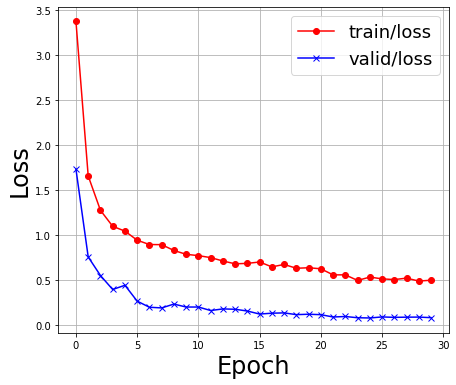

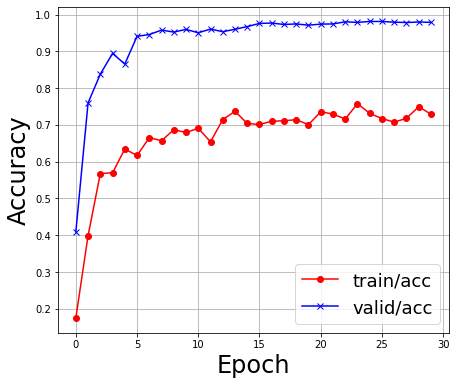

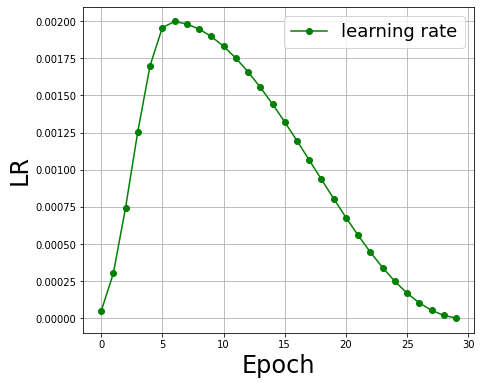

In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_loss, color="r", marker="o", label='train/loss')
plt.plot(valid_loss, color="b", marker="x", label='valid/loss')
plt.ylabel('Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/loss.png')


train_acc = metrics['train_acc'].dropna().reset_index(drop=True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop=True)
    
fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_acc, color="r", marker="o", label='train/acc')
plt.plot(valid_acc, color="b", marker="x", label='valid/acc')
plt.ylabel('Accuracy', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='lower right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/acc.png')

lr = metrics['lr'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(lr, color="g", marker="o", label='learning rate')
plt.ylabel('LR', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/lr.png')

## Prediction

In [ ]:

@torch.no_grad()
def infer(path):
    pl.seed_everything(CFG.seed)
    
    datamodule = LitDataModule()
    datamodule.setup()
    test_dataloader = datamodule.test_dataloader()
    
    module = LitModule.load_eval_checkpoint(path, device=CFG.device)
    
    image_ids = []
    prediction_list = []
    pred_0 = None
    for batch in tqdm(test_dataloader):
        images = batch["image"].to(CFG.device, dtype=torch.float)
        ids = batch['target']
        outputs = module(images)

        if pred_0 is None:
          pred_0 = outputs.data.cpu().numpy()
        else:
          pred_0 = np.vstack((pred_0, outputs.data.cpu().numpy()))

        preds = outputs.argmax(1).cpu().numpy()
        for pred in preds:
            prediction_list.append(index2label[pred])
        image_ids.extend(ids)
        
    prediction_df = pd.DataFrame({'image_id': image_ids, 'label': prediction_list})
    prediction_df.to_csv('submission.csv', index=False)

    return prediction_df, pred_0

In [ ]:
# path = trainer.checkpoint_callback.best_model_path
# # path = trainer.checkpoint_callback.last_model_path

submission_df, pred_1 = infer('/content/logs/tf_efficientnet_b0_ns/version_0/checkpoints/best_acc=0-epoch=24-valid_loss=0.0785-valid_acc=0.9813.ckpt')
submission_df.head()

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


None


  0%|          | 0/109 [00:00<?, ?it/s]

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [ ]:
np.save('a', pred_1)